In [1]:
from tqdm.autonotebook import tqdm
import torchxrayvision as xrv
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import tarfile
from pathlib import Path

/var/folders/md/qxkcfv650bx_kd_5hlgqrct40000gn/T/ipykernel_42504/2362623414.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Extracting and Loading X-Ray Data

Using previously extracted files...
Loading dataset from ./data/NIH/extracted/images-224
Dataset size: 28868

Available pathologies:
1. Atelectasis
2. Cardiomegaly
3. Consolidation
4. Edema
5. Effusion
6. Emphysema
7. Fibrosis
8. Hernia
9. Infiltration
10. Mass
11. Nodule
12. Pleural_Thickening
13. Pneumonia
14. Pneumothorax

Pathology counts:
Atelectasis:
  Present: 1557
  Absent: 27311
  Percentage: 5.39%

Cardiomegaly:
  Present: 729
  Absent: 28139
  Percentage: 2.53%

Consolidation:
  Present: 384
  Absent: 28484
  Percentage: 1.33%

Edema:
  Present: 39
  Absent: 28829
  Percentage: 0.14%

Effusion:
  Present: 1269
  Absent: 27599
  Percentage: 4.40%

Emphysema:
  Present: 264
  Absent: 28604
  Percentage: 0.91%

Fibrosis:
  Present: 556
  Absent: 28312
  Percentage: 1.93%

Hernia:
  Present: 81
  Absent: 28787
  Percentage: 0.28%

Infiltration:
  Present: 3273
  Absent: 25595
  Percentage: 11.34%

Mass:
  Present: 1213
  Absent: 27655
  Percentage: 4.20%

Nodule:
  Present: 1609

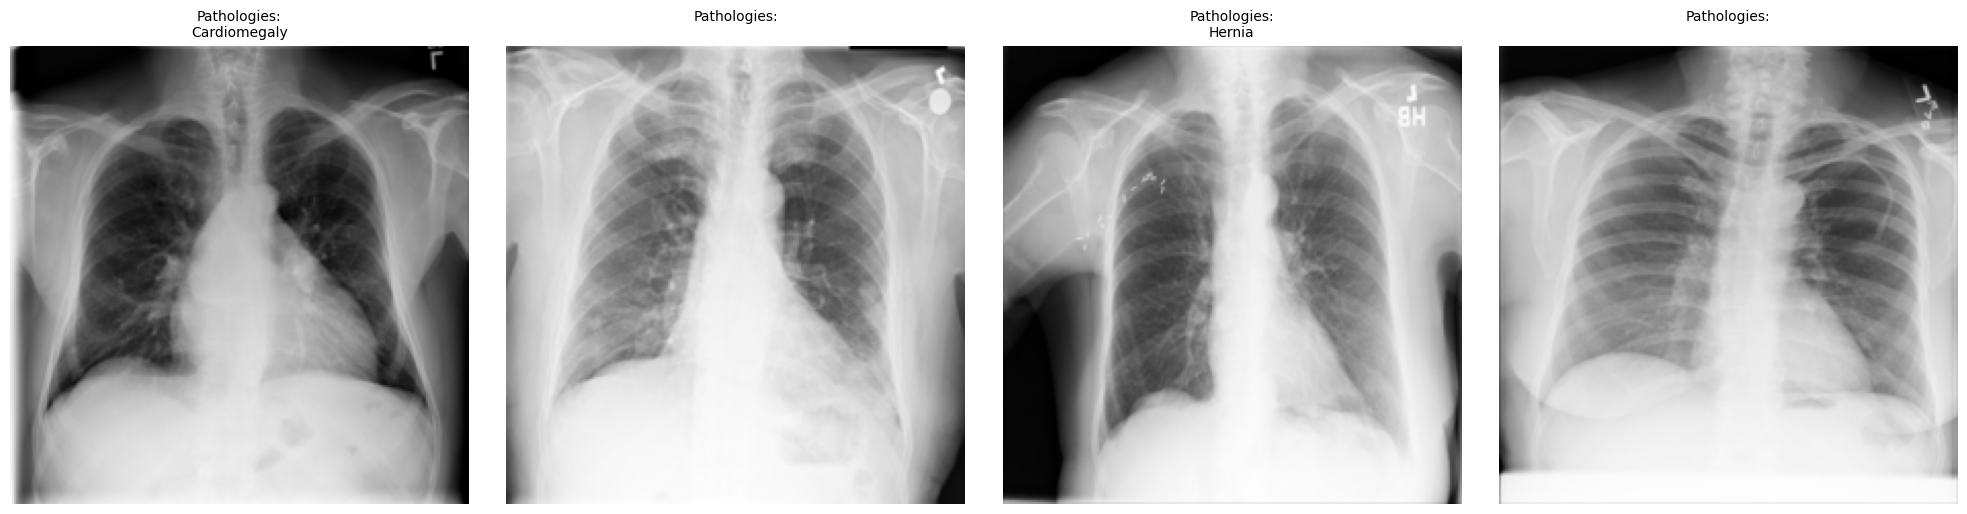

In [2]:
def extract_tar_if_needed(tar_path, extract_dir):
    """
    Extract tar file if it hasn't been extracted already
    
    Parameters:
    tar_path (str): Path to the tar file
    extract_dir (str): Directory to extract to
    
    Returns:
    str: Path to the directory containing the extracted images
    """
    # Create extract directory if it doesn't exist
    Path(extract_dir).mkdir(parents=True, exist_ok=True)
    
    # Check if files are already extracted
    images_dir = os.path.join(extract_dir, 'images-224')
    if os.path.exists(images_dir) and len(os.listdir(images_dir)) > 0:
        print("Using previously extracted files...")
        return images_dir
    
    print(f"Extracting {tar_path} to {extract_dir}...")
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path=extract_dir)
    
    return images_dir

def load_nih_dataset(
    imgpath,
    extract_dir="./data/NIH/extracted",
    views=['PA'],
    unique_patients=True,
    transform=None,
    batch_size=32,
    pathology_masks=False
):
    """
    Load the NIH ChestX-ray14 dataset using TorchXRayVision
    
    Parameters:
    imgpath (str): Path to either the tar file or directory containing NIH dataset images
    extract_dir (str): Directory to extract tar file to if needed
    views (list): List of views to include (default: ['PA'])
    unique_patients (bool): Whether to include only unique patients (default: True)
    transform: Optional transforms to apply (default: None)
    batch_size (int): Batch size for data loader (default: 32)
    pathology_masks (bool): Whether to include pathology masks (default: False)
    
    Returns:
    dataset: NIH_Dataset object
    dataloader: DataLoader object
    """
    # Handle tar file if provided
    if imgpath.endswith('.tar'):
        images_dir = extract_tar_if_needed(imgpath, extract_dir)
    else:
        images_dir = imgpath
    
    # Verify the directory exists and contains images
    if not os.path.isdir(images_dir):
        raise Exception(f"Could not find valid directory at {images_dir}")
    
    print(f"Loading dataset from {images_dir}")
    
    # Initialize the NIH dataset
    dataset = xrv.datasets.NIH_Dataset(
        imgpath=images_dir,
        views=views,
        unique_patients=unique_patients,
        transform=transform,
        pathology_masks=pathology_masks
    )
    
    # Create data loader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )
    
    return dataset, dataloader

def print_dataset_info(dataset):
    """
    Print information about the dataset
    
    Parameters:
    dataset: NIH_Dataset object
    """
    print(f"Dataset size: {len(dataset)}")
    print(f"\nAvailable pathologies:")
    for i, pathology in enumerate(dataset.pathologies):
        print(f"{i+1}. {pathology}")
    
    print("\nPathology counts:")
    totals = dataset.totals()
    for pathology in totals:
        present = totals[pathology].get(1.0, 0)
        absent = totals[pathology].get(0.0, 0)
        print(f"{pathology}:")
        print(f"  Present: {present}")
        print(f"  Absent: {absent}")
        print(f"  Percentage: {(present/(present+absent))*100:.2f}%\n")

def show_sample_images(dataset, num_samples=4):
    """
    Display sample images from the dataset
    
    Parameters:
    dataset: NIH_Dataset object
    num_samples (int): Number of samples to display
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for i in range(num_samples):
        # Get sample and print its structure to debug
        sample = dataset[i]
        print(f"Sample {i} structure:", sample.keys() if hasattr(sample, 'keys') else type(sample))
        
        try:
            if isinstance(sample, dict):
                # If it's a dictionary
                img = sample['img'] if 'img' in sample else sample['image']
                label = sample['lab'] if 'lab' in sample else sample['label']
            else:
                # If it's any other type of sequence
                img, label = sample
            
            if isinstance(img, torch.Tensor):
                img = img.numpy()
            
            # Display the image
            axes[i].imshow(img[0] if img.ndim > 2 else img, cmap='gray')
            axes[i].axis('off')
            
            # Get pathologies present in this image
            pathologies_present = [
                dataset.pathologies[j] 
                for j in range(len(label)) 
                if label[j] == 1
            ]
            
            axes[i].set_title(
                "Pathologies:\n" + "\n".join(pathologies_present),
                fontsize=10
            )
        except Exception as e:
            print(f"Error processing sample {i}:", e)
            print("Sample content:", sample)
    
    plt.tight_layout()
    plt.show()

imgpath = "./data/NIH/images-224.tar"

# Load dataset
dataset, dataloader = load_nih_dataset(
    imgpath=imgpath,
    extract_dir="./data/NIH/extracted",
    views=['PA'],
    unique_patients=True
)

# Print dataset information
print_dataset_info(dataset)

# Show sample images
show_sample_images(dataset)

## Loading Pre-trained Dense Net Model

In [3]:
model = xrv.models.DenseNet(weights="densenet121-res224-nih")

## Running Base Inference Pipeline with Model

Dataset structure:
Using subset dataset
Original dataset type: <class 'torchxrayvision.datasets.NIH_Dataset'>

Number of pathologies: 14
Pathologies: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Batch information:
Batch type: <class 'dict'>
Batch keys: dict_keys(['idx', 'lab', 'img'])
Images shape: torch.Size([4, 1, 224, 224])
Labels shape: torch.Size([4, 14])

Predictions shape: (4, 18)

Debug - Prediction vector length: 18
Debug - Number of pathologies: 14
Debug - Model pathologies: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', '', '', '', '']

Debug - Prediction vector length: 18
Debug - Number of pathologies: 14
Debug - Model pathologies: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumotho

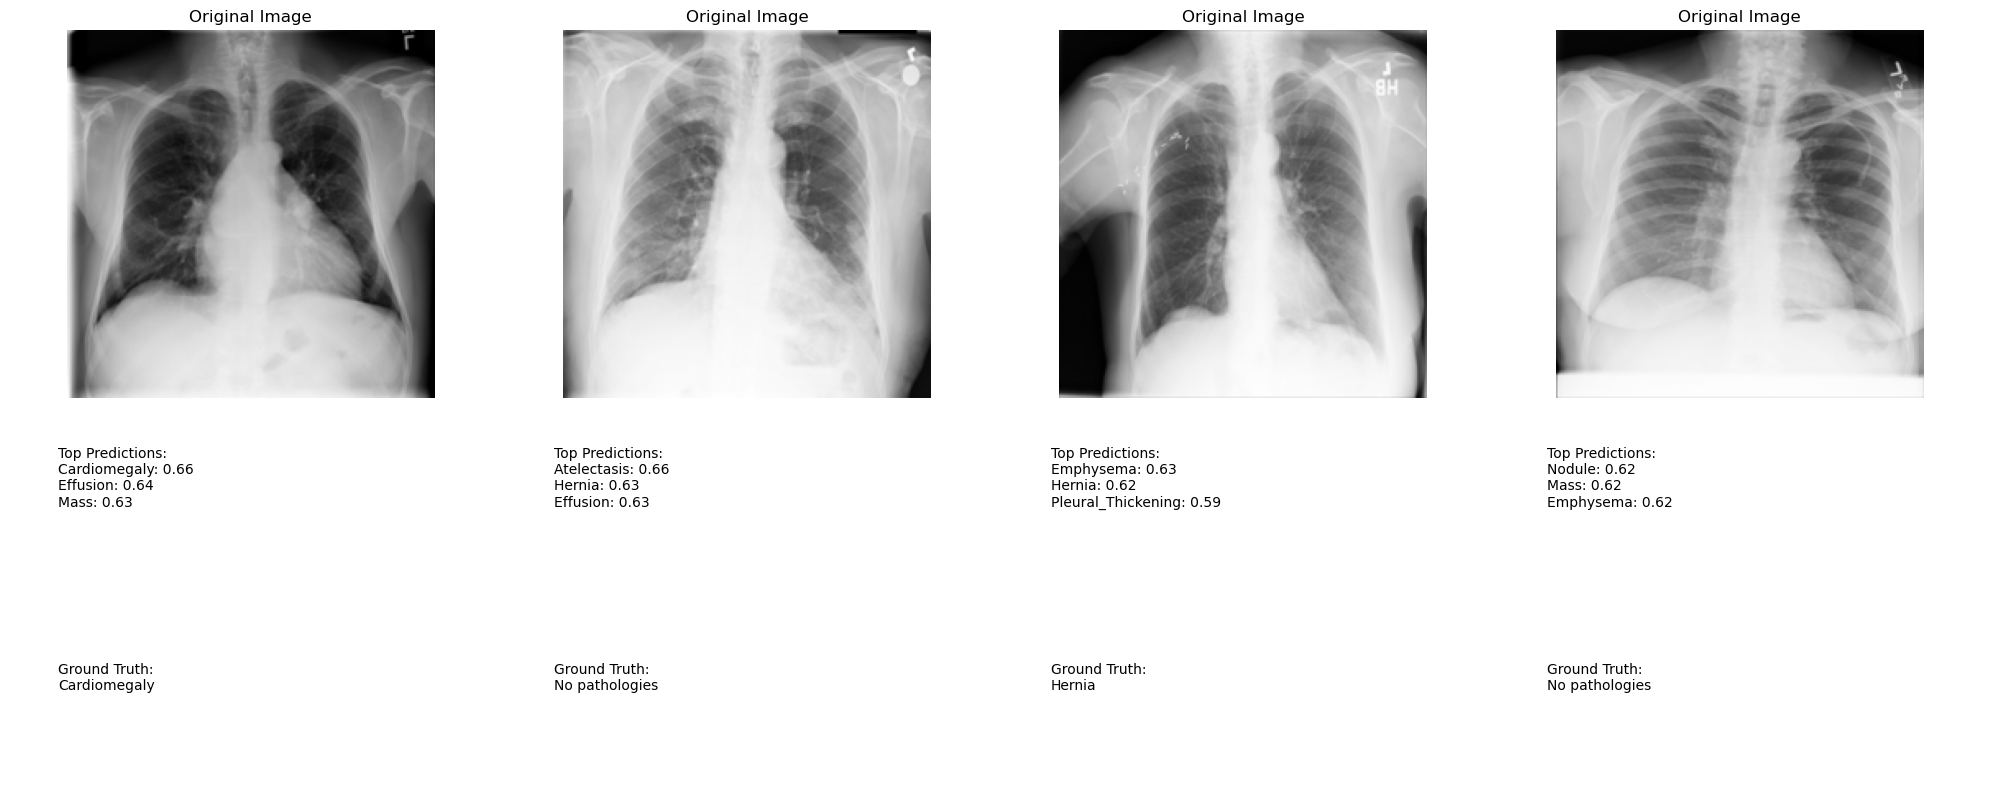

In [4]:
import torch
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

def run_inference(model, dataloader, num_samples=4, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Run inference on images and visualize results
    
    Parameters:
    model: Pre-trained torchxrayvision model
    dataloader: DataLoader containing the images
    num_samples: Number of samples to visualize
    device: Device to run inference on
    """
    model = model.to(device)
    model.eval()
    
    # Debug print dataset structure
    print("Dataset structure:")
    if hasattr(dataloader.dataset, 'dataset'):
        print("Using subset dataset")
        print(f"Original dataset type: {type(dataloader.dataset.dataset)}")
        if hasattr(dataloader.dataset.dataset, 'pathologies'):
            pathologies = list(dataloader.dataset.dataset.pathologies)
        else:
            print("Warning: No pathologies found in dataset")
    else:
        print(f"Dataset type: {type(dataloader.dataset)}")
        if hasattr(dataloader.dataset, 'pathologies'):
            pathologies = list(dataloader.dataset.pathologies)
        else:
            print("Warning: No pathologies found in dataset")
    
    # Default NIH pathologies if none found
    if not pathologies:
        pathologies = [
            'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
            'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
            'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
        ]
    
    print(f"\nNumber of pathologies: {len(pathologies)}")
    print("Pathologies:", pathologies)
    
    # Get a batch of images
    try:
        batch = next(iter(dataloader))
        print("\nBatch information:")
        print(f"Batch type: {type(batch)}")
        
        if isinstance(batch, dict):
            print("Batch keys:", batch.keys())
            images = batch['img'][:num_samples]
            true_labels = batch['lab'][:num_samples]
        else:
            print("Batch length:", len(batch))
            images, true_labels = batch
            images = images[:num_samples]
            true_labels = true_labels[:num_samples]
        
        print(f"Images shape: {images.shape}")
        print(f"Labels shape: {true_labels.shape}")
        
        # Validate shapes match pathologies
        assert true_labels.shape[1] == len(pathologies), \
            f"Mismatch between number of labels ({true_labels.shape[1]}) and pathologies ({len(pathologies)})"
        
        images = images.to(device)
        
        # Run inference
        with torch.no_grad():
            predictions = model(images)
            predictions = torch.sigmoid(predictions).cpu().numpy()
            true_labels = true_labels.cpu().numpy()
        
        print(f"\nPredictions shape: {predictions.shape}")
        
        # Visualize results
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
        
        for i in range(num_samples):
            # Display original image
            img = images[i].cpu().numpy()
            axes[0, i].imshow(img[0], cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Original Image')
            
            # Get predictions for this image
            img_preds = predictions[i]
            img_true = true_labels[i]
            
            print(f"\nDebug - Prediction vector length: {len(img_preds)}")
            print(f"Debug - Number of pathologies: {len(pathologies)}")
            
            # Get model's pathologies
            model_pathologies = model.pathologies
            print(f"Debug - Model pathologies: {model_pathologies}")
            
            # Create mapping between model and dataset pathologies
            pathology_mapping = {i: model_pathologies.index(p) for i, p in enumerate(pathologies) if p in model_pathologies}
            
            # Map predictions to our pathology list
            mapped_preds = np.zeros(len(pathologies))
            for dataset_idx, model_idx in pathology_mapping.items():
                mapped_preds[dataset_idx] = img_preds[model_idx]
            
            # Find top 3 predicted pathologies
            top_pred_idx = np.argsort(mapped_preds)[-3:][::-1]
            
            pred_text = "Top Predictions:\n"
            for idx in top_pred_idx:
                pred_text += f"{pathologies[idx]}: {mapped_preds[idx]:.2f}\n"
            
            # Find actual pathologies
            true_path_idx = np.where(img_true == 1)[0]
            true_text = "Ground Truth:\n"
            if len(true_path_idx) > 0:
                for idx in true_path_idx:
                    true_text += f"{pathologies[idx]}\n"
            else:
                true_text += "No pathologies\n"
            
            # Add texts to plot
            axes[1, i].text(0.1, 0.7, pred_text, transform=axes[1, i].transAxes)
            axes[1, i].text(0.1, 0.2, true_text, transform=axes[1, i].transAxes)
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"\nError during inference: {str(e)}")
        raise

def calculate_metrics(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Calculate model performance metrics on the dataset
    
    Parameters:
    model: Pre-trained torchxrayvision model
    dataloader: DataLoader containing the images
    device: Device to run inference on
    
    Returns:
    dict: Dictionary containing performance metrics
    """
    model = model.to(device)
    model.eval()
    
    # Get pathologies list
    if hasattr(dataloader.dataset, 'dataset'):
        pathologies = dataloader.dataset.dataset.pathologies
    elif hasattr(dataloader.dataset, 'pathologies'):
        pathologies = dataloader.dataset.pathologies
    else:
        pathologies = [
            'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
            'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
            'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
        ]
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating metrics"):
            if isinstance(batch, dict):
                images = batch['img']
                labels = batch['lab']
            else:
                images, labels = batch
            
            images = images.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs)
            
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Combine all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    # Calculate metrics
    metrics = {}
    
    for i, pathology in enumerate(pathologies):
        # Calculate accuracy for each pathology
        pred_binary = (all_preds[:, i] > 0.5).astype(int)
        accuracy = np.mean(pred_binary == all_labels[:, i])
        
        # Store metrics
        metrics[pathology] = {
            'accuracy': accuracy,
            'positive_samples': np.sum(all_labels[:, i] == 1),
            'negative_samples': np.sum(all_labels[:, i] == 0)
        }
    
    return metrics

# Create a small subset for testing
small_subset = torch.utils.data.Subset(dataset, indices=range(4))  # Just 4 samples
test_loader = DataLoader(small_subset, batch_size=4)

# Run inference
run_inference(model, test_loader, num_samples=4)

## Counting length of dataset

In [5]:
i = 0
for d in dataset:
    i += 1
i

28868

## Taking subset and splitting into train and test

In [6]:
train_dataset = torch.utils.data.Subset(dataset, indices=range(5000))
train_loader = DataLoader(train_dataset, batch_size=4)

test_dataset = torch.utils.data.Subset(dataset, indices=range(5000, 6000))
test_loader = DataLoader(test_dataset, batch_size=4)

## Using Dense Net to extract features and training Bayes Net

In [7]:
import time
import torch
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import os
from pathlib import Path

def extract_features(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Extract features from images using the pretrained model
    
    Parameters:
    model: Pretrained torchxrayvision model
    dataloader: DataLoader containing the images
    device: Device to run inference on
    
    Returns:
    features: Extracted features (n_samples, n_features)
    labels: Ground truth labels (n_samples, n_classes)
    """
    model = model.to(device)
    model.eval()
    
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting features"):
            if isinstance(batch, dict):
                images = batch['img']
                labels = batch['lab']
            else:
                images, labels = batch
            
            images = images.to(device)
            
            # Forward pass through the model
            features = model.features(images)
            
            # Global average pooling
            features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
            features = features.view(features.size(0), -1)
            
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    return np.concatenate(features_list), np.concatenate(labels_list)

def reduce_dimensions(features, method='pca', n_components=100, random_state=42):
    """
    Reduce dimensionality of features
    
    Parameters:
    features: Feature matrix (n_samples, n_features)
    method: Dimensionality reduction method ('pca', 'tsne', or 'umap')
    n_components: Number of components to keep
    random_state: Random seed for reproducibility
    
    Returns:
    reduced_features: Reduced feature matrix (n_samples, n_components)
    reducer: Fitted dimensionality reduction model
    """
    # First, standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Apply dimensionality reduction
    if method.lower() == 'pca':
        reducer = PCA(n_components=n_components, random_state=random_state)
        reduced_features = reducer.fit_transform(scaled_features)
        # Print explained variance ratio
        explained_var = np.sum(reducer.explained_variance_ratio_)
        print(f"PCA with {n_components} components explains {explained_var:.2%} of variance")
    
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=random_state)
        reduced_features = reducer.fit_transform(scaled_features)
    
    elif method.lower() == 'umap':
        try:
            import umap
            reducer = umap.UMAP(n_components=n_components, random_state=random_state)
            reduced_features = reducer.fit_transform(scaled_features)
        except ImportError:
            print("UMAP not installed. Please install it with 'pip install umap-learn'")
            print("Falling back to PCA...")
            reducer = PCA(n_components=n_components, random_state=random_state)
            reduced_features = reducer.fit_transform(scaled_features)
    
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")
    
    return reduced_features, reducer, scaler

def discretize_features(features, n_bins=5):
    """
    Discretize continuous features into bins for Bayesian network
    
    Parameters:
    features: Continuous feature matrix
    n_bins: Number of bins for discretization
    
    Returns:
    discretized: Discretized feature matrix
    bin_edges: Edges of the bins for each feature
    """
    discretized = np.zeros_like(features, dtype=int)
    bin_edges = []
    
    for i in range(features.shape[1]):
        hist, edges = np.histogram(features[:, i], bins=n_bins)
        discretized[:, i] = np.digitize(features[:, i], edges[:-1])
        bin_edges.append(edges)
    
    return discretized, bin_edges

def construct_bayesian_network(features, labels, pathologies, n_bins=5):
    """
    Construct a Bayesian network from features and labels
    
    Parameters:
    features: Discretized feature matrix
    labels: Binary label matrix
    pathologies: List of pathology names
    n_bins: Number of bins used in discretization
    
    Returns:
    model: Fitted Bayesian network
    """
    # Create DataFrame for pgmpy
    feature_cols = [f'f{i}' for i in range(features.shape[1])]
    pathology_cols = pathologies
    
    data = pd.DataFrame(
        np.hstack([features, labels]),
        columns=feature_cols + pathology_cols
    )
    
    # Define network structure
    # For simplicity, we'll create a naive Bayes structure for each pathology
    edges = []
    for p in pathology_cols:
        for f in feature_cols:
            edges.append((p, f))
    
    # Create and fit Bayesian network
    model = BayesianNetwork(edges)
    
    # Estimate CPDs using MLE
    mle = MaximumLikelihoodEstimator(model=model, data=data)
    
    # Fit CPDs for each node
    for node in model.nodes():
        cpd = mle.estimate_cpd(node)
        model.add_cpds(cpd)
    
    return model

def save_model_and_metadata(model, bin_edges, reducer, scaler, output_dir, method):
    """
    Save model with additional metadata
    
    Parameters:
    model: Bayesian network model
    bin_edges: Bin edges for discretization
    reducer: Fitted dimensionality reduction model
    scaler: Fitted scaler model
    output_dir: Directory to save models and metadata
    method: Dimensionality reduction method used
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    print("Saving model and metadata...")
    start_time = time.time()
    model.save(os.path.join(output_dir, 'bayesian_network_train.bif'), filetype='bif')
    
    # Save metadata
    np.save(os.path.join(output_dir, 'bin_edges_train.npy'), bin_edges)
    
    # Save dimensionality reduction models
    if method.lower() == 'pca':
        np.save(os.path.join(output_dir, 'pca_components_train.npy'), reducer.components_)
        np.save(os.path.join(output_dir, 'pca_mean_train.npy'), reducer.mean_)
        np.save(os.path.join(output_dir, 'explained_variance_train.npy'), reducer.explained_variance_ratio_)
    
    # Save scaler parameters
    np.save(os.path.join(output_dir, 'scaler_mean_train.npy'), scaler.mean_)
    np.save(os.path.join(output_dir, 'scaler_scale_train.npy'), scaler.scale_)
    
    print(f"Model and metadata saved in {time.time() - start_time:.1f} seconds")

def main(model, dataloader, pathologies, output_dir='./models', 
         n_bins=5, dim_reduction_method='pca', n_components=100):
    """
    Main function to extract features, reduce dimensions, and build Bayesian network
    
    Parameters:
    model: Pretrained torchxrayvision model
    dataloader: DataLoader containing the images
    pathologies: List of pathology names
    output_dir: Directory to save the model
    n_bins: Number of bins for feature discretization
    dim_reduction_method: Dimensionality reduction method ('pca', 'tsne', or 'umap')
    n_components: Number of components to keep after dimensionality reduction
    
    Returns:
    bayes_net: Fitted Bayesian network
    bin_edges: Bin edges for discretization
    reducer: Fitted dimensionality reduction model
    """
    print("Extracting features...")
    features, labels = extract_features(model, dataloader)
    
    print(f"Original feature dimension: {features.shape[1]}")
    
    print(f"Applying dimensionality reduction using {dim_reduction_method}...")
    reduced_features, reducer, scaler = reduce_dimensions(
        features, 
        method=dim_reduction_method,
        n_components=n_components
    )
    print(f"Reduced feature dimension: {reduced_features.shape[1]}")
    
    print("Discretizing features...")
    discretized_features, bin_edges = discretize_features(reduced_features, n_bins)
    
    print("Constructing Bayesian network...")
    bayes_net = construct_bayesian_network(
        discretized_features, 
        labels,
        pathologies,
        n_bins
    )
    
    # Save model and metadata
    save_model_and_metadata(
        bayes_net, 
        bin_edges, 
        reducer, 
        scaler, 
        output_dir,
        dim_reduction_method
    )
    
    return bayes_net, bin_edges, reducer, scaler

pathologies = dataset.pathologies

# Run the main pipeline with dimensionality reduction
bayes_net, bin_edges, reducer, scaler = main(
    model=model,
    dataloader=train_loader,
    #dataloader=dataloader,
    pathologies=pathologies,
    output_dir='./models',
    n_bins=5,  
    dim_reduction_method='pca',  # Options: 'pca', 'tsne', 'umap'
    n_components=100  # Adjust as needed
)

Extracting features...


Extracting features:   0%|          | 0/1250 [00:00<?, ?it/s]

Original feature dimension: 1024
Applying dimensionality reduction using pca...
PCA with 100 components explains 99.56% of variance
Reduced feature dimension: 100
Discretizing features...
Constructing Bayesian network...
Saving model and metadata...
Model and metadata saved in 5.3 seconds


## Load Pre-trained Bayes Net if available

In [ ]:
from pgmpy.readwrite import BIFReader

# Load the model from BIF file
reader = BIFReader("./models/bayesian_network_train.bif")
bayes_net = reader.get_model()

# Now you can use the model
print("Nodes:", bayes_net.nodes())
print("Edges:", bayes_net.edges())

## Obtaining Predicted values for train set from Bayes Net

In [8]:
print("Extracting features...")
features, labels = extract_features(model, train_loader)
# features, labels = extract_features(model, dataloader)

reduced_features, reducer, scaler = reduce_dimensions(features, n_components=100)

print("Discretizing features...")

discretized_features, bin_edges = discretize_features(reduced_features)

feature_cols = [f'f{i}' for i in range(discretized_features.shape[1])]
pathology_cols = pathologies

data = pd.DataFrame(
    np.hstack([discretized_features]),
    columns=feature_cols
)

#bayes_pred_prob = bayes_net.predict_probability(data)
bayes_pred = bayes_net.predict(data)

Extracting features...


Extracting features:   0%|          | 0/1250 [00:00<?, ?it/s]

PCA with 100 components explains 99.56% of variance
Discretizing features...


  0%|          | 0/5000 [00:00<?, ?it/s]

## Evaluate classification results on train data

In [9]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

labels = []
for i in range(5000):
    labels.append(dataset[i]["lab"])

label_df = pd.DataFrame(np.array(labels))
label_df.columns = dataset.pathologies
#label_str_df = label_df.astype(str)

for path in dataset.pathologies:
    # Convert string predictions to correct format for sklearn
    true_labels = label_df[path]#.map({'0.0': 0, '1.0': 1})
    pred_labels = bayes_pred[path]#.map({'0.0': 0, '1.0': 1})
    
    # Now calculate metrics with the correctly formatted labels
    print(f"Evaluation for {path}:")
    print(f"Baseline: {1-true_labels.mean()}")
    print(confusion_matrix(true_labels, pred_labels))
    print(f"Accuracy Score: {accuracy_score(true_labels, pred_labels)}")
    print(f"F1 Score: {f1_score(true_labels, pred_labels)}")

Evaluation for Atelectasis:
Baseline: 0.9462000131607056
[[4706   25]
 [ 123  146]]
Accuracy Score: 0.9704
F1 Score: 0.6636363636363637
Evaluation for Cardiomegaly:
Baseline: 0.9674000144004822
[[4786   51]
 [  40  123]]
Accuracy Score: 0.9818
F1 Score: 0.7299703264094956
Evaluation for Consolidation:
Baseline: 0.9879999756813049
[[4935    5]
 [   3   57]]
Accuracy Score: 0.9984
F1 Score: 0.9344262295081968
Evaluation for Edema:
Baseline: 0.9987999796867371
[[4994    0]
 [   0    6]]
Accuracy Score: 1.0
F1 Score: 1.0
Evaluation for Effusion:
Baseline: 0.9581999778747559
[[4731   60]
 [  62  147]]
Accuracy Score: 0.9756
F1 Score: 0.7067307692307693
Evaluation for Emphysema:
Baseline: 0.9876000285148621
[[4924   14]
 [  17   45]]
Accuracy Score: 0.9938
F1 Score: 0.743801652892562
Evaluation for Fibrosis:
Baseline: 0.9706000089645386
[[4816   37]
 [  68   79]]
Accuracy Score: 0.979
F1 Score: 0.6007604562737643
Evaluation for Hernia:
Baseline: 0.996399998664856
[[4981    1]
 [   1   17]]
A

## Predict and evaluate on test data

In [10]:
# Step 1: Extract features from test set
print("Extracting features from test set...")
test_features, test_labels = extract_features(model, test_loader)

# Step 2: Apply the same preprocessing steps as during training
print("Preprocessing test features...")
# Apply the same scaler that was fit on the training data
scaled_test_features = scaler.transform(test_features)

# Apply the same dimensionality reduction that was fit on the training data
if hasattr(reducer, 'transform'):
    reduced_test_features = reducer.transform(scaled_test_features)
else:
    # For methods like TSNE that don't have transform
    print("Dimensionality reduction method doesn't support transform, using fit_transform")
    reduced_test_features = reducer.fit_transform(scaled_test_features)

# Step 3: Discretize the features using the same bin edges from training
print("Discretizing test features...")
discretized_test_features = np.zeros_like(reduced_test_features, dtype=int)
for i in range(reduced_test_features.shape[1]):
    discretized_test_features[:, i] = np.digitize(reduced_test_features[:, i], bin_edges[i][:-1])

# Step 4: Create DataFrame for inference
feature_cols = [f'f{i}' for i in range(discretized_test_features.shape[1])]
test_data = pd.DataFrame(
    discretized_test_features,
    columns=feature_cols
)

for col in data.columns:
    train_feat = set(data[col].unique())
    test_feat = set(test_data[col].unique())
    
    # Find values in test_data that don't exist in training data
    test_only_values = test_feat - train_feat
    
    if len(test_only_values) > 0:
        print(f"Column: {col}")
        print(f"Values in test but not in training: {test_only_values}")
        
        for m in test_only_values:
            # Find the closest value in training data to replace with
            if m-1 in train_feat:
                replacement = m-1
            elif m+1 in train_feat:
                replacement = m+1
            else:
                # If no close values, use the most common value in training data
                replacement = data[col].mode()[0]
                
            print(f"Replacing {m} with {replacement} in test data")
            test_data.loc[test_data[col] == m, col] = replacement

# Step 5: Run inference on the test set
print("Running inference on test set...")
test_predictions = bayes_net.predict(test_data)

# Step 6: Prepare test labels for evaluation
test_labels_df = pd.DataFrame(test_labels)
test_labels_df.columns = pathologies

# Step 7: Evaluate results for each pathology
print("\nEvaluation Results:")
results = {}

for path in pathologies:
    # Get true labels and predictions for this pathology
    true_labels = test_labels_df[path]
    pred_labels = test_predictions[path]
    
    # Calculate metrics
    acc = accuracy_score(true_labels, pred_labels)
    baseline_acc = max(true_labels.mean(), 1 - true_labels.mean())  # Majority class baseline
    f1 = f1_score(true_labels, pred_labels)
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Store results
    results[path] = {
        'accuracy': acc,
        'baseline_accuracy': baseline_acc,
        'improvement': acc - baseline_acc,
        'f1_score': f1,
        'confusion_matrix': cm
    }
    
    # Print results
    print(f"\nPathology: {path}")
    print(f"Baseline Accuracy (majority class): {baseline_acc:.4f}")
    print(f"Model Accuracy: {acc:.4f}")
    print(f"Improvement over baseline: {(acc - baseline_acc) * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

# Step 8: Calculate aggregate metrics
avg_acc = np.mean([results[path]['accuracy'] for path in pathologies])
avg_baseline = np.mean([results[path]['baseline_accuracy'] for path in pathologies])
avg_f1 = np.mean([results[path]['f1_score'] for path in pathologies])

print("\nAggregate Results:")
print(f"Average Accuracy: {avg_acc:.4f}")
print(f"Average Baseline: {avg_baseline:.4f}")
print(f"Average Improvement: {(avg_acc - avg_baseline) * 100:.2f}%")
print(f"Average F1 Score: {avg_f1:.4f}")

Extracting features from test set...


Extracting features:   0%|          | 0/250 [00:00<?, ?it/s]

Preprocessing test features...
Discretizing test features...
Column: f7
Values in test but not in training: {np.int64(0)}
Replacing 0 with 1 in test data
Column: f10
Values in test but not in training: {np.int64(0)}
Replacing 0 with 1 in test data
Column: f12
Values in test but not in training: {np.int64(0)}
Replacing 0 with 1 in test data
Column: f21
Values in test but not in training: {np.int64(0)}
Replacing 0 with 1 in test data
Column: f39
Values in test but not in training: {np.int64(0)}
Replacing 0 with 1 in test data
Column: f42
Values in test but not in training: {np.int64(0)}
Replacing 0 with 1 in test data
Column: f47
Values in test but not in training: {np.int64(0)}
Replacing 0 with 1 in test data
Column: f59
Values in test but not in training: {np.int64(0)}
Replacing 0 with 1 in test data
Column: f63
Values in test but not in training: {np.int64(0)}
Replacing 0 with 1 in test data
Column: f70
Values in test but not in training: {np.int64(0)}
Replacing 0 with 1 in test data


  0%|          | 0/1000 [00:00<?, ?it/s]


Evaluation Results:

Pathology: Atelectasis
Baseline Accuracy (majority class): 0.9460
Model Accuracy: 0.9420
Improvement over baseline: -0.40%
F1 Score: 0.0333
Confusion Matrix:
[[941   5]
 [ 53   1]]

Pathology: Cardiomegaly
Baseline Accuracy (majority class): 0.9700
Model Accuracy: 0.9610
Improvement over baseline: -0.90%
F1 Score: 0.2353
Confusion Matrix:
[[955  15]
 [ 24   6]]

Pathology: Consolidation
Baseline Accuracy (majority class): 0.9810
Model Accuracy: 0.9810
Improvement over baseline: 0.00%
F1 Score: 0.0000
Confusion Matrix:
[[981   0]
 [ 19   0]]

Pathology: Edema
Baseline Accuracy (majority class): 0.9970
Model Accuracy: 0.9970
Improvement over baseline: 0.00%
F1 Score: 0.0000
Confusion Matrix:
[[997   0]
 [  3   0]]

Pathology: Effusion
Baseline Accuracy (majority class): 0.9610
Model Accuracy: 0.9450
Improvement over baseline: -1.60%
F1 Score: 0.2029
Confusion Matrix:
[[938  23]
 [ 32   7]]

Pathology: Emphysema
Baseline Accuracy (majority class): 0.9870
Model Accura

## Visualizing Bayes Net

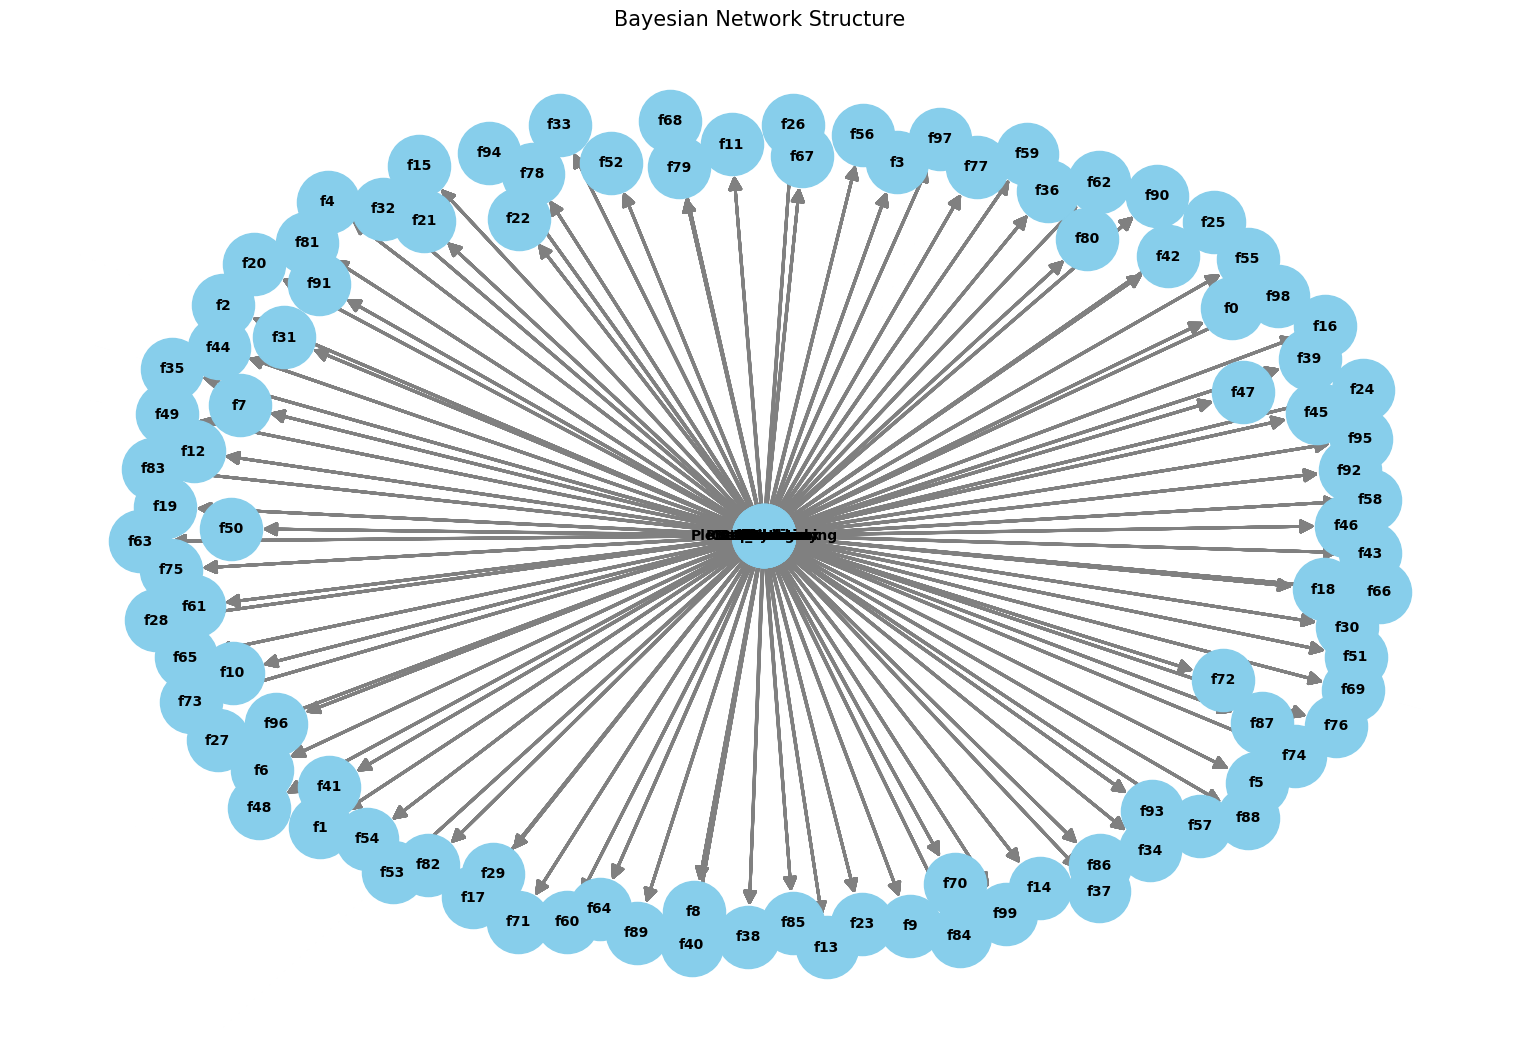

In [11]:
# Import the required libraries
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph from your Bayesian network
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(bayes_net.nodes())

# Add edges
G.add_edges_from(bayes_net.edges())

# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)  # For reproducibility
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        font_size=10, font_weight="bold", arrowsize=20, 
        edge_color="gray", width=2)

plt.title("Bayesian Network Structure", fontsize=15)
plt.tight_layout()
plt.show()

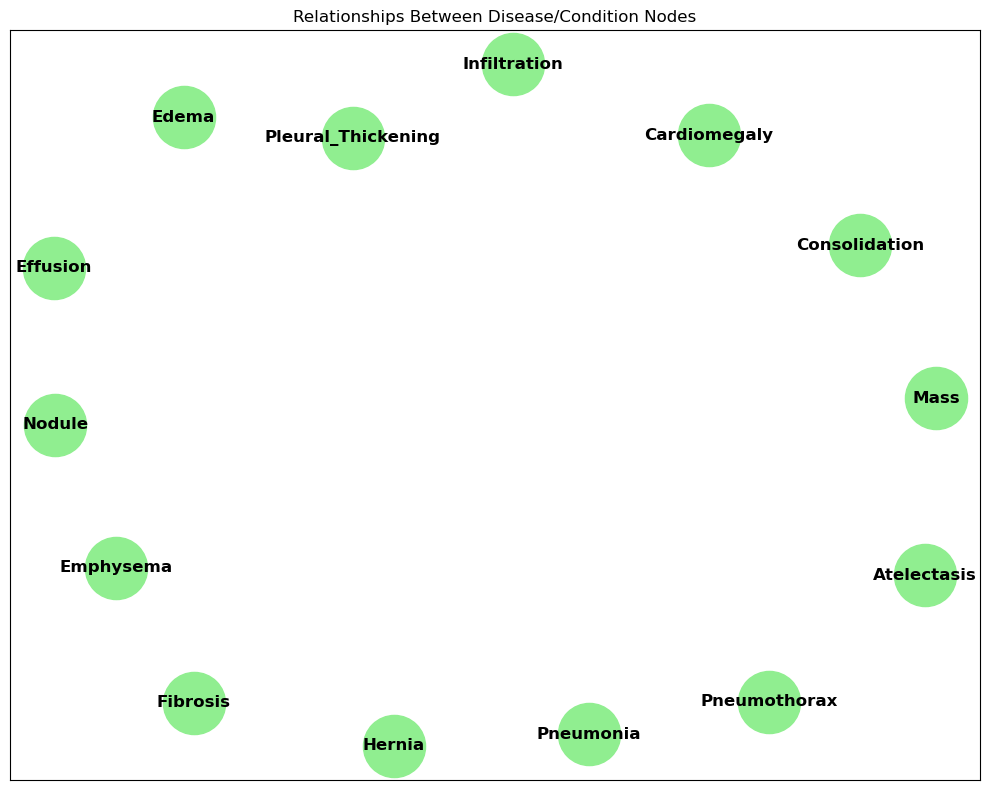

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Assuming bayes_net is your Bayesian network
G = nx.DiGraph()
G.add_nodes_from(bayes_net.nodes())
G.add_edges_from(bayes_net.edges())

# Identify disease/condition nodes vs feature nodes
disease_nodes = [n for n in G.nodes() if not n.startswith('f')]
feature_nodes = [n for n in G.nodes() if n.startswith('f')]

# Option 1: Show just the disease/condition nodes and their relationships
disease_graph = G.subgraph(disease_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(disease_graph, seed=42)
nx.draw_networkx(disease_graph, pos, 
                node_color='lightgreen',
                node_size=2000,
                font_size=12,
                font_weight='bold')
plt.title("Relationships Between Disease/Condition Nodes")
plt.tight_layout()
plt.show()

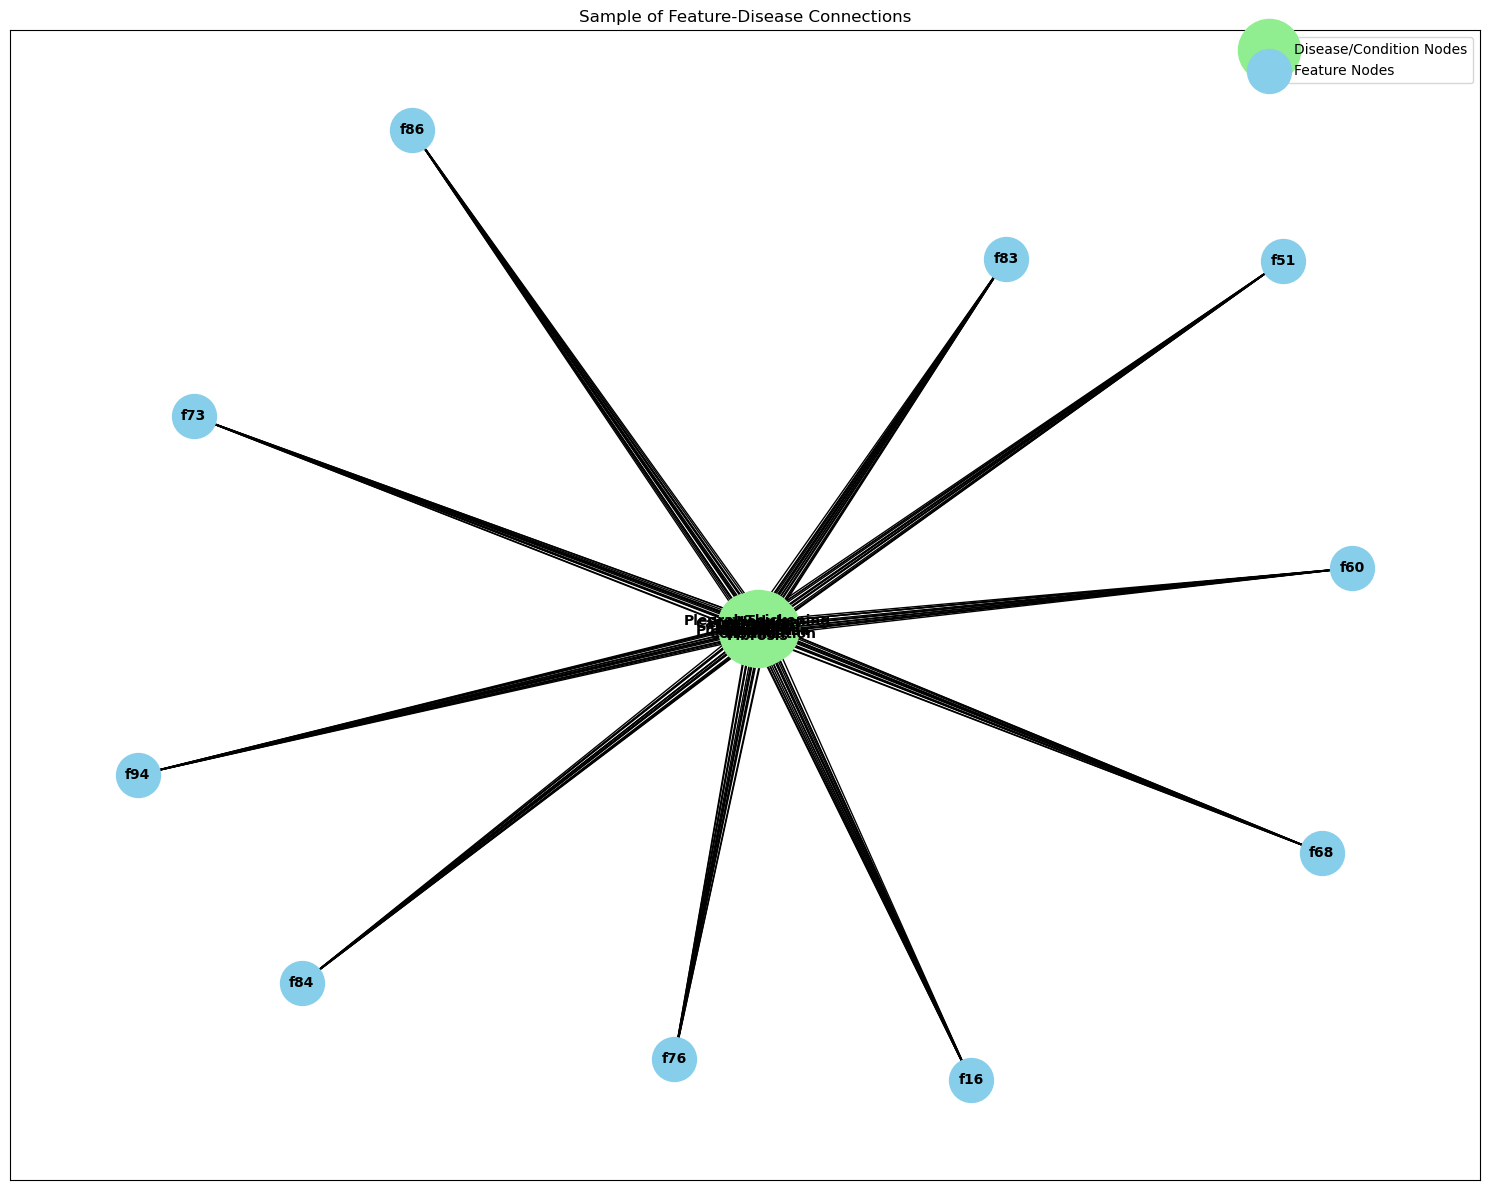

In [13]:
# Option 2: Show a sample of feature nodes connecting to each disease
plt.figure(figsize=(15, 12))
sample_size = min(10, len(feature_nodes))  # Take at most 10 feature nodes
sampled_features = np.random.choice(feature_nodes, sample_size, replace=False)
important_nodes = list(disease_nodes) + list(sampled_features)
subgraph = G.subgraph(important_nodes)

pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_nodes(subgraph, pos,
                      nodelist=disease_nodes,
                      node_color='lightgreen',
                      node_size=2000)
nx.draw_networkx_nodes(subgraph, pos,
                      nodelist=sampled_features,
                      node_color='skyblue',
                      node_size=1000)
nx.draw_networkx_edges(subgraph, pos, arrows=True)
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')

plt.title("Sample of Feature-Disease Connections")
plt.tight_layout()
plt.legend(["Disease/Condition Nodes", "Feature Nodes"])
plt.show()

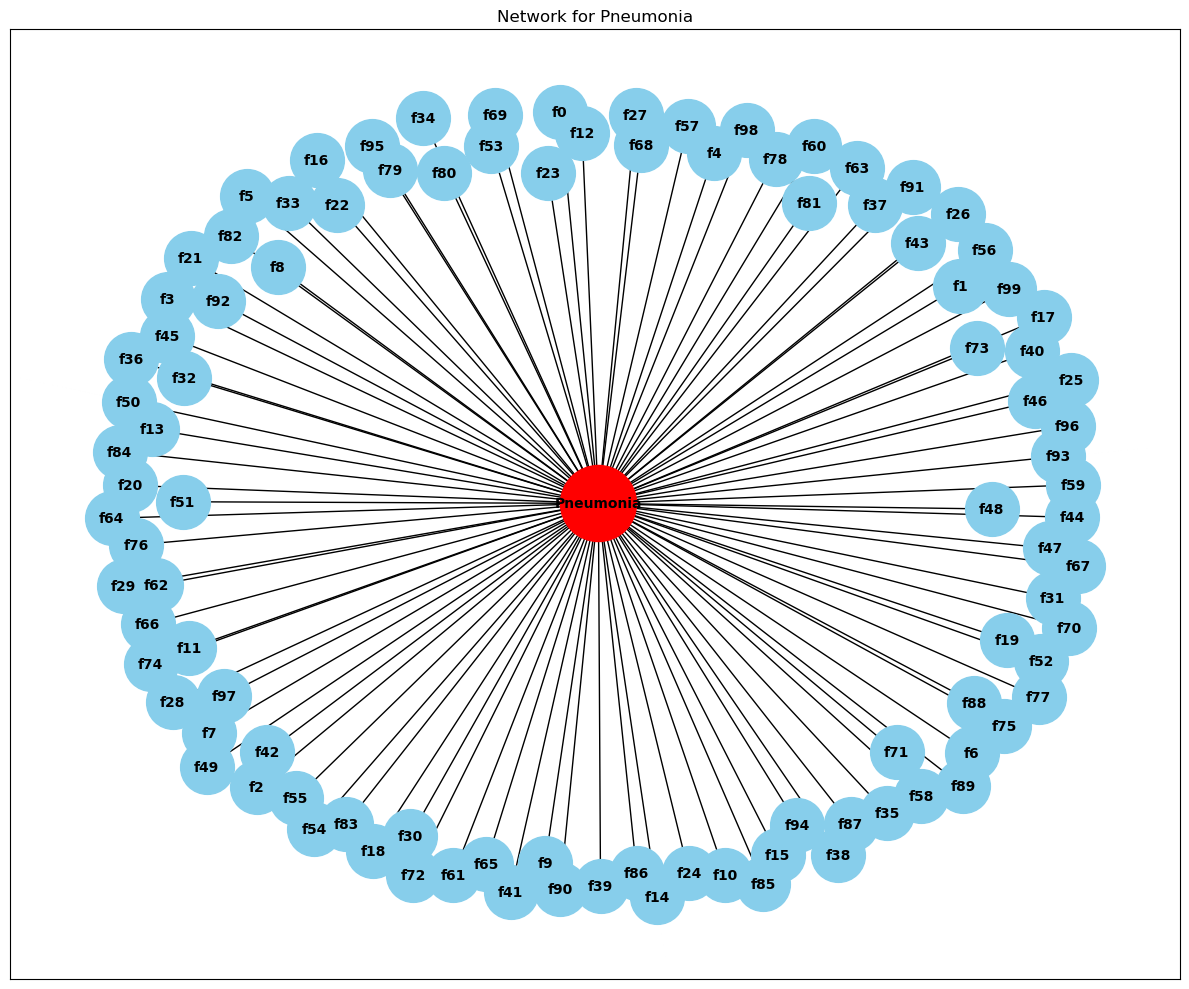

In [14]:
# Option 3: Show one disease and its directly connected features
disease_of_interest = "Pneumonia"  # Change to any disease node
neighbors = list(G.predecessors(disease_of_interest)) + list(G.successors(disease_of_interest))
relevant_nodes = [disease_of_interest] + neighbors

subgraph = G.subgraph(relevant_nodes)
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(subgraph, pos,
                      nodelist=[disease_of_interest],
                      node_color='red',
                      node_size=3000)
nx.draw_networkx_nodes(subgraph, pos,
                      nodelist=[n for n in subgraph.nodes() if n != disease_of_interest],
                      node_color='skyblue',
                      node_size=1500)
nx.draw_networkx_edges(subgraph, pos, arrows=True)
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')

plt.title(f"Network for {disease_of_interest}")
plt.tight_layout()
plt.show()

## Appendix

In [ ]:
print("Extracting features...")
features, labels = extract_features(model, test_loader)
# features, labels = extract_features(model, dataloader)

# Load the saved parameters from separate files
mean = np.load('./models/scaler_mean_train.npy')
scale = np.load('./models/scaler_scale_train.npy')

# Create a new scaler
scaler = StandardScaler()

# Manually set the parameters
scaler.mean_ = mean
scaler.scale_ = scale
# Compute var_ from scale (since var_ = 1/scale_^2 in StandardScaler)
scaler.var_ = 1 / (scale ** 2)
# Set n_features_in_ to the length of mean
scaler.n_features_in_ = len(mean)

scaled_features = scaler.transform(features)

components = np.load('./models/pca_components_train.npy')
pca_mean = np.load('./models/pca_mean_train.npy')
explained_variance = np.load('./models/explained_variance_train.npy')
reducer = PCA(n_components=components.shape[0])
reducer.components_ = components
reducer.n_components_ = components.shape[0]
reducer.n_features_ = components.shape[1]
reducer.explained_variance_ = explained_variance
reducer.mean_ = pca_mean
reduced_features = reducer.transform(scaled_features)